# Biathlon Data Science Project

* Data source: Real Biatholon Statistics [link](http://www.realbiathlon.com/p/statistics-women.html)
* 2015-2016 Season Biathlon World Cup Womens Shooting Times: [link](http://realbiathlon.sportsontheweb.net/data2/WomenShootingTimes_files/sheet016.htm)
* 2015-2016 Season Biathlon World Cup Womens Results: [link](http://realbiathlon.sportsontheweb.net/data2/WomenResults_files/sheet016.htm)

### Definition of Features

From the metadata on the data source we have the following definition of the features.

| Feature  | Description |
|--------------|-------------|
|  Family Name  | |
|  Given Name  | |
|  Nation  | |
|  Races  |  Finished individual, non-relay races|
|  Sh_Time_P |  Average Shooting Time in individual, non-relay races - Prone|
|  Sh_Time_S |  Average Shooting Time in individual, non-relay races - Standing|
|  Sh_Time_T |  Average Shooting Time in individual, non-relay races - Total|
|  Sh_Time_IN |  Average Shooting Time in individual, non-relay races - Individual|
|  Sh_Time_SP |  Average Shooting Time in individual, non-relay races - Sprint|
|  Sh_Time_PU |  Average Shooting Time in individual, non-relay races - Pursuit|
|  Sh_Time_MS |  Average Shooting Time in individual, non-relay races - Mass Start|
|  Sh_Time_P |  Average Shooting Time in individual, non-relay races - Prone|
|  Rg_Time_S |  Average Range Time in individual, non-relay races - Standing|
|  Rg_Time_T |  Average Range Time in individual, non-relay races - Total|
|  Rg_Time_IN |  Average Range Time in individual, non-relay races - Individual|
|  Rg_Time_SP |  Average Range Time in individual, non-relay races - Sprint|
|  Rg_Time_PU |  Average Range Time in individual, non-relay races - Pursuit|
|  Rg_Time_MS |  Average Range Time in individual, non-relay races - Mass Start|
|  Penalty Loop  |  Season average penalty loop (approximation)|



### What we can do next
* Merge shooting time dataframe with results dataframe to create a target for training our model
    * We can do this by creating a unique key using first and last name and reindex by this key
* Statistical analysis -- what is the spread of each category? Vizualize this
* Feature selection -- What categories might contribute more to the final ranking? ("Skiing is for show, shooting is for dough")
* Train a model to predict placement. How accurate is it? Would combining data from different years yield better results?
* How have the categories changed throughout the years? Is the sport getting more competitive?

In [2]:
import pandas as pd
import matplotlib.pyplot as plt      # matplotlib.pyplot plots data
import seaborn as sns
import datetime

%matplotlib inline

The dataset already contains an index column. We can either set this column as the index in our data frame, our we can choose to drop the first column in our dataset. I am doing the former below. Further, we see a large number of NaN's. Let's go ahead and convert these to 0:00.0 to be consistent. While we're at it, let's also rename the columns to something less confusing.

In [4]:
df_sh_times = pd.read_csv("shooting_time.csv", index_col=0)
df_sh_times = df_sh_times.fillna('0:00.0')
df_sh_times = df_sh_times.rename(columns={'Sh Time\nP': 'Sh_Time_P', 
                        'Sh Time\nS': 'Sh_Time_S',
                        'Sh Time\nT': 'Sh_Time_T',
                        'Rg Time\nP': 'Rg_Time_P',
                        'Rg Time\nS': 'Rg_Time_S',
                        'Rg Time\nT': 'Rg_Time_T',
                        'Sh Time\nIN': 'Sh_Time_IN',
                        'Sh Time\nSP': 'Sh_Time_SP',
                        'Sh Time\nPu': 'Sh_Time_PU',
                        'Sh Time\nMS': 'Sh_Time_MS',
                        'Rg Time\nIN': 'Rg_Time_IN',
                        'Rg Time\nSP': 'Rg_Time_SP',
                        'Rg Time\nPU': 'Rg_Time_PU',
                        'Rg Time\nMS': 'Rg_Time_MS',
                        'Penalty\nLoop': "Penalty Loop"})
df_sh_times.head()

,Family Name,Given Name,Nation,Races,Sh_Time_P,Sh_Time_S,Sh_Time_T,Rg_Time_P,Rg_Time_S,Rg_Time_T,Sh_Time_IN,Sh_Time_SP,Sh_Time_PU,Sh_Time_MS,Rg_Time_IN,Rg_Time_SP,Rg_Time_PU,Rg_Time_MS,Penalty Loop
1,KAISHEVA,Uliana,RUS,1,0:26.0,0:23.0,0:24.5,0:41.8,0:41.7,0:41.8,0:00.0,0:24.5,0:00.0,0:00.0,0:00.0,0:41.8,0:00.0,0:00.0,0:26.0
2,KUMMER,Luise,GER,6,0:26.0,0:23.9,0:24.9,0:48.1,0:45.9,0:47.0,0:00.0,0:25.5,0:25.0,0:24.0,0:00.0,0:46.1,0:49.3,0:43.7,0:26.4
3,HAUSER,Lisa Theresa,AUT,24,0:27.3,0:23.0,0:25.1,0:48.3,0:43.6,0:46.0,0:24.9,0:25.3,0:25.2,0:25.0,0:46.3,0:46.6,0:46.6,0:44.0,0:25.3
4,ZDOUC,Dunja,AUT,11,0:28.0,0:23.7,0:25.8,0:49.5,0:45.1,0:47.3,0:27.0,0:26.7,0:23.1,0:00.0,0:47.5,0:49.3,0:43.6,0:00.0,0:25.8
5,WIERER,Dorothea,ITA,25,0:27.1,0:25.0,0:26.1,0:47.2,0:44.9,0:46.1,0:25.5,0:25.5,0:26.2,0:26.6,0:45.5,0:45.9,0:46.2,0:46.3,0:23.5


We see that the times are stored as string. Let's write a function to convert each of the times to total seconds.

In [5]:
def str_to_sec(val):
    minute, seconds = val.split(":")
    sec, msec = seconds.split(".")
    total_sec = int(minute)*60 + int(sec) + int(msec)/10
    return total_sec

In [7]:
for c in df_sh_times.columns[4::]:
    df_sh_times[c] = df_sh_times[c].apply(lambda x: str_to_sec(x))
    
df_sh_times.head()

,Family Name,Given Name,Nation,Races,Sh_Time_P,Sh_Time_S,Sh_Time_T,Rg_Time_P,Rg_Time_S,Rg_Time_T,Sh_Time_IN,Sh_Time_SP,Sh_Time_PU,Sh_Time_MS,Rg_Time_IN,Rg_Time_SP,Rg_Time_PU,Rg_Time_MS,Penalty Loop
1,KAISHEVA,Uliana,RUS,1,26.0,23.0,24.5,41.8,41.7,41.8,0.0,24.5,0.0,0.0,0.0,41.8,0.0,0.0,26.0
2,KUMMER,Luise,GER,6,26.0,23.9,24.9,48.1,45.9,47.0,0.0,25.5,25.0,24.0,0.0,46.1,49.3,43.7,26.4
3,HAUSER,Lisa Theresa,AUT,24,27.3,23.0,25.1,48.3,43.6,46.0,24.9,25.3,25.2,25.0,46.3,46.6,46.6,44.0,25.3
4,ZDOUC,Dunja,AUT,11,28.0,23.7,25.8,49.5,45.1,47.3,27.0,26.7,23.1,0.0,47.5,49.3,43.6,0.0,25.8
5,WIERER,Dorothea,ITA,25,27.1,25.0,26.1,47.2,44.9,46.1,25.5,25.5,26.2,26.6,45.5,45.9,46.2,46.3,23.5


Much better! Now that the data is in a more workable format, let's dive deeper into what the dataset looks like. Some things we might be interested in include the shape, a summary of each column (number of entries, data types etc), and a correlation matrix to pick out any redundancies.

In [6]:
# Look at the shape of the dataframe (number of rows and columns)
print("This data set has {rows} rows and {cols} columns".format(rows=df_sh_times.shape[0], cols=df_sh_times.shape[1]))

This data set has 165 rows and 19 columns


In [8]:
# look a a summary of each column (number of entries, data-type etc)
df_sh_times.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 165 entries, 1 to 165
Data columns (total 19 columns):
Family Name     165 non-null object
Given Name      165 non-null object
Nation          165 non-null object
Races           165 non-null int64
Sh_Time_P       165 non-null float64
Sh_Time_S       165 non-null float64
Sh_Time_T       165 non-null float64
Rg_Time_P       165 non-null float64
Rg_Time_S       165 non-null float64
Rg_Time_T       165 non-null float64
Sh_Time_IN      165 non-null float64
Sh_Time_SP      165 non-null float64
Sh_Time_PU      165 non-null float64
Sh_Time_MS      165 non-null float64
Rg_Time_IN      165 non-null float64
Rg_Time_SP      165 non-null float64
Rg_Time_PU      165 non-null float64
Rg_Time_MS      165 non-null float64
Penalty Loop    165 non-null float64
dtypes: float64(15), int64(1), object(3)
memory usage: 25.8+ KB


In [9]:
# Check for any null values
df_sh_times.isnull().values.any()

False

In [10]:
def plot_pretty_corr(df):
    plt.figure(figsize=(12, 12))
    corr = df.corr()
    ax = sns.heatmap(corr,
                    vmin=-1,
                    vmax=1,
                    center=0,
                    cmap=sns.diverging_palette(20, 220, n=200),
        square=True
    )
    ax.set_xticklabels(
        ax.get_xticklabels(),
        rotation=45,
        horizontalalignment='right'
    );

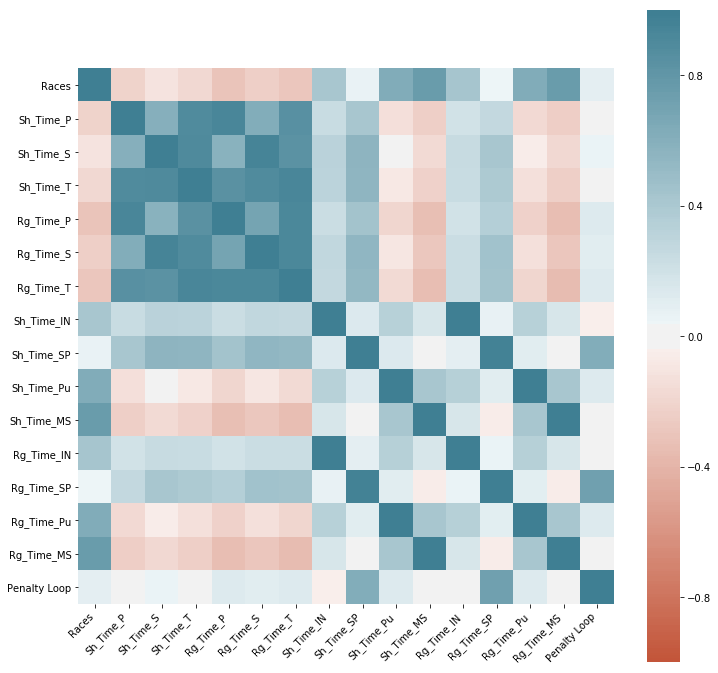

In [10]:
plot_pretty_corr(df_sh_times)

In [50]:
# Generate descriptive statistics that summarize the central tendency, dispersion and shape of a dataset’s distribution
df_sh_times.describe()

,Races,Sh_Time_P,Sh_Time_S,Sh_Time_T,Rg_Time_P,Rg_Time_S,Rg_Time_T,Sh_Time_IN,Sh_Time_SP,Sh_Time_PU,Sh_Time_MS,Rg_Time_IN,Rg_Time_SP,Rg_Time_PU,Rg_Time_MS,Penalty Loop
count,165.000000,165.000000,165.000000,165.000000,165.000000,165.000000,165.000000,165.000000,165.000000,165.000000,165.000000,165.000000,165.000000,165.000000,165.000000,165.000000
mean,10.533333,34.374545,31.185455,32.778788,56.015152,52.765455,54.395758,27.626667,32.316970,21.819394,9.781818,45.372121,53.828485,36.421212,16.213939,24.883636
std,7.250343,3.836548,4.115575,3.545519,4.523362,4.539953,4.167563,13.260477,5.766954,15.060848,14.394419,21.361924,8.496275,24.950108,23.763409,4.683017
min,1.000000,26.000000,22.400000,24.500000,41.800000,41.700000,41.800000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.000000,31.700000,28.600000,30.500000,52.900000,49.900000,51.600000,28.900000,30.200000,0.000000,0.000000,50.200000,51.800000,0.000000,0.000000,24.500000
50%,10.000000,34.000000,31.000000,32.800000,55.500000,52.700000,54.200000,32.500000,33.000000,30.200000,0.000000,53.600000,54.700000,51.400000,0.000000,25.500000
75%,16.000000,37.000000,33.500000,34.800000,59.200000,55.000000,56.700000,34.800000,35.000000,33.200000,27.300000,56.600000,57.200000,54.000000,46.300000,26.400000
max,25.000000,46.400000,50.500000,47.300000,70.000000,74.000000,70.900000,52.200000,44.700000,39.500000,38.600000,76.400000,67.400000,63.400000,59.700000,34.600000


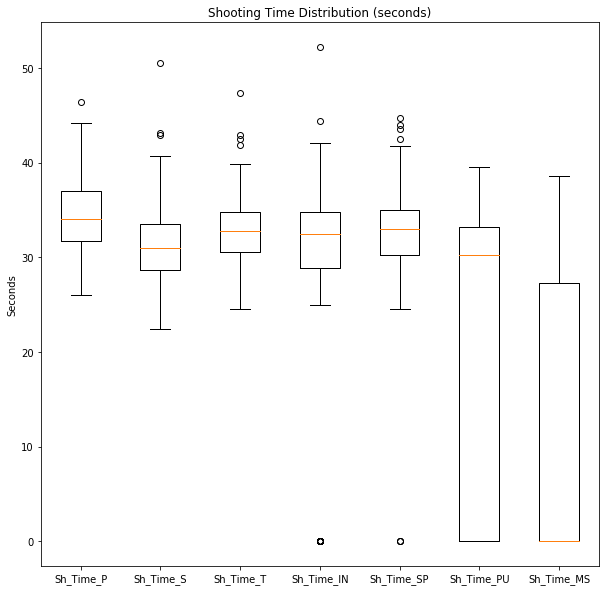

In [52]:
# Vizualize using box plots
plt.figure(figsize=(10,10))
plt.boxplot([df_sh_times["Sh_Time_P"],
             df_sh_times["Sh_Time_S"], 
             df_sh_times["Sh_Time_T"],
             df_sh_times["Sh_Time_IN"],
             df_sh_times["Sh_Time_SP"],
             df_sh_times["Sh_Time_PU"],
             df_sh_times["Sh_Time_MS"],
            ],
            labels = ["Sh_Time_P", "Sh_Time_S", "Sh_Time_T",
                      "Sh_Time_IN", "Sh_Time_SP", "Sh_Time_PU", "Sh_Time_MS"])
plt.ylabel("Seconds")
plt.title("Shooting Time Distribution (seconds)")
plt.show()

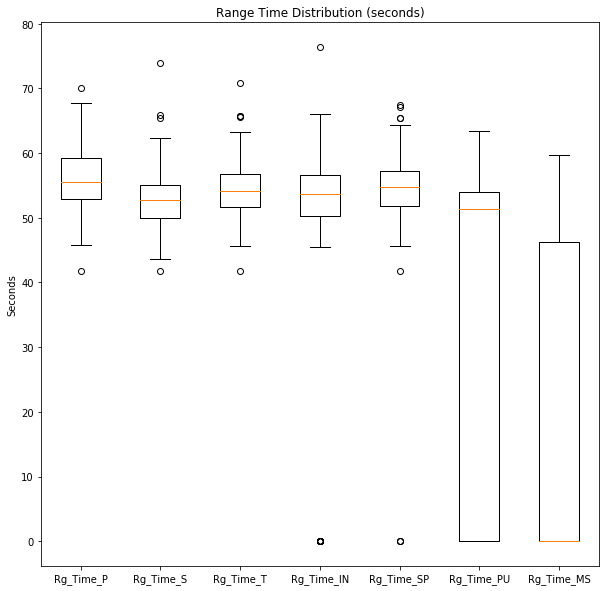

In [53]:
# Vizualize using box plots
plt.figure(figsize=(10,10))
plt.boxplot([df_sh_times["Rg_Time_P"],
             df_sh_times["Rg_Time_S"], 
             df_sh_times["Rg_Time_T"],
             df_sh_times["Rg_Time_IN"],
             df_sh_times["Rg_Time_SP"],
             df_sh_times["Rg_Time_PU"],
             df_sh_times["Rg_Time_MS"],
            ],
            labels = ["Rg_Time_P", "Rg_Time_S", "Rg_Time_T",
                      "Rg_Time_IN", "Rg_Time_SP", "Rg_Time_PU", "Rg_Time_MS"])
plt.ylabel("Seconds")
plt.title("Range Time Distribution (seconds)")
plt.show()